# Logistic

In [100]:
# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

train = pd.read_csv('train.csv')

X_train = train.drop(columns=['Class.pH', 'ID'])
y_train = train['Class.pH']

# --- 1. Target Mapping ---
target_map = {
    "Strongly acidic": -2,
    "Moderately acidic": -1,
    "Neutral": 0,
    "Moderately alkaline": 1,
    "Strongly alkaline": 2
}

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID and target column from numeric_cols
numeric_cols = [col for col in numeric_cols if col not in ['ID', 'Class.pH']]

# Map target column and drop rows with unmapped labels
y_train = train['Class.pH'].astype(str).str.strip().map(target_map)
valid_idx = ~y_train.isna()
X_train = train.loc[valid_idx, numeric_cols].reset_index(drop=True)
y_train = y_train.loc[valid_idx].astype(int).reset_index(drop=True)

print("Unique classes after mapping:", sorted(y_train.unique()))
print("Any NaNs left in y_train?", y_train.isna().sum())

# --- 2. Optional: Drop low-signal columns (like SILT) ---
# drop_features = ['SILT', 'OM', 'EC', 'BD', 'N']  # can tweak
# X_train = X_train.drop(columns=[col for col in drop_features if col in X_train.columns])

# --- 3. Define Pipeline ---
pipe_logistic = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=True)),
    ("logit", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=1516))
])

# --- 4. Cross-Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1516)
f1_scores = []
y_oof = np.zeros(len(X_train), dtype=int)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    # Sanity check per fold
    if y_tr.isna().any() or y_val.isna().any():
        raise ValueError(f"NaNs detected in y during fold {fold}")

    pipe_logistic.fit(X_tr, y_tr)
    y_pred = pipe_logistic.predict(X_val)

    f1 = f1_score(y_val, y_pred, average="macro")
    f1_scores.append(f1)
    y_oof[va_idx] = y_pred

    print(f"Fold {fold} F1 (macro): {f1:.4f}")

# --- 5. Overall Performance ---
print("\n=== Cross-Validation Summary ===")
print(f"Mean F1 (macro): {np.mean(f1_scores):.4f}")

print("\n=== Classification Report (OOF) ===")
print(classification_report(y_train, y_oof, digits=3))

print("\n=== Confusion Matrix (OOF) ===")
print(confusion_matrix(y_train, y_oof))

logistic_oof = y_oof.copy()

Unique classes after mapping: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2)]
Any NaNs left in y_train? 0
Fold 1 F1 (macro): 0.3775
Fold 2 F1 (macro): 0.3826
Fold 3 F1 (macro): 0.3656
Fold 4 F1 (macro): 0.4006
Fold 5 F1 (macro): 0.4245

=== Cross-Validation Summary ===
Mean F1 (macro): 0.3901

=== Classification Report (OOF) ===
              precision    recall  f1-score   support

          -2      0.252     0.581     0.352       215
          -1      0.489     0.332     0.396       776
           0      0.268     0.386     0.316       438
           1      0.755     0.453     0.566      1290
           2      0.243     0.485     0.323       293

    accuracy                          0.424      3012
   macro avg      0.401     0.447     0.391      3012
weighted avg      0.530     0.424     0.447      3012


=== Confusion Matrix (OOF) ===
[[125  52  26   0  12]
 [224 258 213  37  44]
 [ 54  98 169  67  50]
 [ 74 101 194 584 337]
 [ 19  19  28  85 142]]


# KNN

In [101]:
# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

train = pd.read_csv('train.csv')

X_train = train.drop(columns=['Class.pH', 'ID'])
y_train = train['Class.pH']

# --- 1. Target Mapping ---
target_map = {
    "Strongly acidic": -2,
    "Moderately acidic": -1,
    "Neutral": 0,
    "Moderately alkaline": 1,
    "Strongly alkaline": 2
}

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID and target column from numeric_cols
numeric_cols = [col for col in numeric_cols if col not in ['ID', 'Class.pH']]

# Map target column and drop rows with unmapped labels
y_train = train['Class.pH'].astype(str).str.strip().map(target_map)
valid_idx = ~y_train.isna()
X_train = train.loc[valid_idx, numeric_cols].reset_index(drop=True)
y_train = y_train.loc[valid_idx].astype(int).reset_index(drop=True)

print("Unique classes after mapping:", sorted(y_train.unique()))
print("Any NaNs left in y_train?", y_train.isna().sum())

# --- 2. Optional: Drop low-signal columns (like SILT) ---
# drop_features = ['SILT', 'OM', 'EC', 'BD', 'N']  # can tweak
# X_train = X_train.drop(columns=[col for col in drop_features if col in X_train.columns])

# --- 3. Define Pipeline ---
pipe_knn = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=True)),
    ("kneigh", KNeighborsClassifier(n_neighbors=5, weights='uniform', n_jobs=-1))
])

# --- 4. Cross-Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1516)
f1_scores = []
y_oof = np.zeros(len(X_train), dtype=int)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    # Sanity check per fold
    if y_tr.isna().any() or y_val.isna().any():
        raise ValueError(f"NaNs detected in y during fold {fold}")

    pipe_knn.fit(X_tr, y_tr)
    y_pred = pipe_knn.predict(X_val)

    f1 = f1_score(y_val, y_pred, average="macro")
    f1_scores.append(f1)
    y_oof[va_idx] = y_pred

    print(f"Fold {fold} F1 (macro): {f1:.4f}")

# --- 5. Overall Performance ---
print("\n=== Cross-Validation Summary ===")
print(f"Mean F1 (macro): {np.mean(f1_scores):.4f}")

print("\n=== Classification Report (OOF) ===")
print(classification_report(y_train, y_oof, digits=3))

print("\n=== Confusion Matrix (OOF) ===")
print(confusion_matrix(y_train, y_oof))

kn_oof = y_oof.copy()

Unique classes after mapping: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2)]
Any NaNs left in y_train? 0
Fold 1 F1 (macro): 0.3603
Fold 2 F1 (macro): 0.3824
Fold 3 F1 (macro): 0.3804
Fold 4 F1 (macro): 0.3561
Fold 5 F1 (macro): 0.3905

=== Cross-Validation Summary ===
Mean F1 (macro): 0.3740

=== Classification Report (OOF) ===
              precision    recall  f1-score   support

          -2      0.309     0.237     0.268       215
          -1      0.458     0.586     0.514       776
           0      0.264     0.192     0.222       438
           1      0.633     0.704     0.666      1290
           2      0.396     0.137     0.203       293

    accuracy                          0.511      3012
   macro avg      0.412     0.371     0.375      3012
weighted avg      0.488     0.511     0.489      3012


=== Confusion Matrix (OOF) ===
[[ 51 122  19  21   2]
 [ 72 455  81 159   9]
 [ 16 169  84 166   3]
 [ 23 202 110 908  47]
 [  3  45  24 181  40]]


# SVC

In [102]:
# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix

train = pd.read_csv('train.csv')

X_train = train.drop(columns=['Class.pH', 'ID'])
y_train = train['Class.pH']

# --- 1. Target Mapping ---
target_map = {
    "Strongly acidic": -2,
    "Moderately acidic": -1,
    "Neutral": 0,
    "Moderately alkaline": 1,
    "Strongly alkaline": 2
}

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID and target column from numeric_cols
numeric_cols = [col for col in numeric_cols if col not in ['ID', 'Class.pH']]

# Map target column and drop rows with unmapped labels
y_train = train['Class.pH'].astype(str).str.strip().map(target_map)
valid_idx = ~y_train.isna()
X_train = train.loc[valid_idx, numeric_cols].reset_index(drop=True)
y_train = y_train.loc[valid_idx].astype(int).reset_index(drop=True)

print("Unique classes after mapping:", sorted(y_train.unique()))
print("Any NaNs left in y_train?", y_train.isna().sum())

# --- 2. Optional: Drop low-signal columns (like SILT) ---
# drop_features = ['SILT', 'OM', 'EC', 'BD', 'N']  # can tweak
# X_train = X_train.drop(columns=[col for col in drop_features if col in X_train.columns])

# --- 3. Define Pipeline ---
pipe_svc = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=True)),
    ("svc", SVC(class_weight="balanced", random_state=1516, probability=True))
])

# --- 4. Cross-Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1516)
f1_scores = []
y_oof = np.zeros(len(X_train), dtype=int)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    # Sanity check per fold
    if y_tr.isna().any() or y_val.isna().any():
        raise ValueError(f"NaNs detected in y during fold {fold}")

    pipe_svc.fit(X_tr, y_tr)
    y_pred = pipe_svc.predict(X_val)

    f1 = f1_score(y_val, y_pred, average="macro")
    f1_scores.append(f1)
    y_oof[va_idx] = y_pred

    print(f"Fold {fold} F1 (macro): {f1:.4f}")

# --- 5. Overall Performance ---
print("\n=== Cross-Validation Summary ===")
print(f"Mean F1 (macro): {np.mean(f1_scores):.4f}")

print("\n=== Classification Report (OOF) ===")
print(classification_report(y_train, y_oof, digits=3))

print("\n=== Confusion Matrix (OOF) ===")
print(confusion_matrix(y_train, y_oof))

svc_oof = y_oof.copy()

Unique classes after mapping: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2)]
Any NaNs left in y_train? 0
Fold 1 F1 (macro): 0.4383
Fold 2 F1 (macro): 0.4225
Fold 3 F1 (macro): 0.4111
Fold 4 F1 (macro): 0.4708
Fold 5 F1 (macro): 0.4941

=== Cross-Validation Summary ===
Mean F1 (macro): 0.4474

=== Classification Report (OOF) ===
              precision    recall  f1-score   support

          -2      0.280     0.493     0.358       215
          -1      0.534     0.455     0.491       776
           0      0.307     0.486     0.376       438
           1      0.797     0.500     0.615      1290
           2      0.326     0.522     0.401       293

    accuracy                          0.488      3012
   macro avg      0.449     0.491     0.448      3012
weighted avg      0.575     0.488     0.509      3012


=== Confusion Matrix (OOF) ===
[[106  78  26   4   1]
 [170 353 195  27  31]
 [ 31 109 213  52  33]
 [ 55 100 238 645 252]
 [ 16  21  22  81 153]]


# Random Forest

In [103]:
# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix

train = pd.read_csv('train.csv')

X_train = train.drop(columns=['Class.pH', 'ID'])
y_train = train['Class.pH']

# --- 1. Target Mapping ---
target_map = {
    "Strongly acidic": -2,
    "Moderately acidic": -1,
    "Neutral": 0,
    "Moderately alkaline": 1,
    "Strongly alkaline": 2
}

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID and target column from numeric_cols
numeric_cols = [col for col in numeric_cols if col not in ['ID', 'Class.pH']]

# Map target column and drop rows with unmapped labels
y_train = train['Class.pH'].astype(str).str.strip().map(target_map)
valid_idx = ~y_train.isna()
X_train = train.loc[valid_idx, numeric_cols].reset_index(drop=True)
y_train = y_train.loc[valid_idx].astype(int).reset_index(drop=True)

print("Unique classes after mapping:", sorted(y_train.unique()))
print("Any NaNs left in y_train?", y_train.isna().sum())

# --- 2. Optional: Drop low-signal columns (like SILT) ---
# drop_features = ['SILT', 'OM', 'EC', 'BD', 'N']  # can tweak
# X_train = X_train.drop(columns=[col for col in drop_features if col in X_train.columns])

# --- 3. Define Pipeline ---
pipe_rfc = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=True)),
    ("rfc", RandomForestClassifier(class_weight="balanced", random_state=1516))
])

# --- 4. Cross-Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1516)
f1_scores = []
y_oof = np.zeros(len(X_train), dtype=int)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    # Sanity check per fold
    if y_tr.isna().any() or y_val.isna().any():
        raise ValueError(f"NaNs detected in y during fold {fold}")

    pipe_rfc.fit(X_tr, y_tr)
    y_pred = pipe_rfc.predict(X_val)

    f1 = f1_score(y_val, y_pred, average="macro")
    f1_scores.append(f1)
    y_oof[va_idx] = y_pred

    print(f"Fold {fold} F1 (macro): {f1:.4f}")

# --- 5. Overall Performance ---
print("\n=== Cross-Validation Summary ===")
print(f"Mean F1 (macro): {np.mean(f1_scores):.4f}")

print("\n=== Classification Report (OOF) ===")
print(classification_report(y_train, y_oof, digits=3))

print("\n=== Confusion Matrix (OOF) ===")
print(confusion_matrix(y_train, y_oof))

rfc_oof = y_oof.copy()

Unique classes after mapping: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2)]
Any NaNs left in y_train? 0
Fold 1 F1 (macro): 0.4035
Fold 2 F1 (macro): 0.4304
Fold 3 F1 (macro): 0.3826
Fold 4 F1 (macro): 0.4443
Fold 5 F1 (macro): 0.4290

=== Cross-Validation Summary ===
Mean F1 (macro): 0.4180

=== Classification Report (OOF) ===
              precision    recall  f1-score   support

          -2      0.584     0.209     0.308       215
          -1      0.545     0.746     0.630       776
           0      0.370     0.114     0.175       438
           1      0.658     0.858     0.745      1290
           2      0.732     0.140     0.235       293

    accuracy                          0.605      3012
   macro avg      0.578     0.414     0.419      3012
weighted avg      0.589     0.605     0.552      3012


=== Confusion Matrix (OOF) ===
[[  45  156    2   12    0]
 [  24  579   43  130    0]
 [   4  171   50  212    1]
 [   3  127   39 1107   14]
 [   1   29    1

# LGBM

In [104]:
# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix

train = pd.read_csv('train.csv')

X_train = train.drop(columns=['Class.pH', 'ID'])
y_train = train['Class.pH']

# --- 1. Target Mapping ---
target_map = {
    "Strongly acidic": -2,
    "Moderately acidic": -1,
    "Neutral": 0,
    "Moderately alkaline": 1,
    "Strongly alkaline": 2
}

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID and target column from numeric_cols
numeric_cols = [col for col in numeric_cols if col not in ['ID', 'Class.pH']]

# Map target column and drop rows with unmapped labels
y_train = train['Class.pH'].astype(str).str.strip().map(target_map)
valid_idx = ~y_train.isna()
X_train = train.loc[valid_idx, numeric_cols].reset_index(drop=True)
y_train = y_train.loc[valid_idx].astype(int).reset_index(drop=True)

print("Unique classes after mapping:", sorted(y_train.unique()))
print("Any NaNs left in y_train?", y_train.isna().sum())

# --- 2. Optional: Drop low-signal columns (like SILT) ---
# drop_features = ['SILT', 'OM', 'EC', 'BD', 'N']  # can tweak
# X_train = X_train.drop(columns=[col for col in drop_features if col in X_train.columns])

# --- 3. Define Pipeline ---
pipe_lgbmc = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("lgbmc", LGBMClassifier(class_weight="balanced", random_state=1516))
])

# --- 4. Cross-Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1516)
f1_scores = []
y_oof = np.zeros(len(X_train), dtype=int)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    # Sanity check per fold
    if y_tr.isna().any() or y_val.isna().any():
        raise ValueError(f"NaNs detected in y during fold {fold}")

    pipe_lgbmc.fit(X_tr, y_tr)
    y_pred = pipe_lgbmc.predict(X_val)

    f1 = f1_score(y_val, y_pred, average="macro")
    f1_scores.append(f1)
    y_oof[va_idx] = y_pred

    print(f"Fold {fold} F1 (macro): {f1:.4f}")

# --- 5. Overall Performance ---
print("\n=== Cross-Validation Summary ===")
print(f"Mean F1 (macro): {np.mean(f1_scores):.4f}")

print("\n=== Classification Report (OOF) ===")
print(classification_report(y_train, y_oof, digits=3))

print("\n=== Confusion Matrix (OOF) ===")
print(confusion_matrix(y_train, y_oof))

lgbmc_oof = y_oof.copy()

Unique classes after mapping: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2)]
Any NaNs left in y_train? 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 2409, number of used features: 15
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Fold 1 F1 (macro): 0.4687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1737
[LightGBM] [Info] Number of data points in the train set: 2409, number of used features: 15
[L

# ctb

In [105]:
# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix

train = pd.read_csv('train.csv')

X_train = train.drop(columns=['Class.pH', 'ID'])
y_train = train['Class.pH']

# --- 1. Target Mapping ---
target_map = {
    "Strongly acidic": -2,
    "Moderately acidic": -1,
    "Neutral": 0,
    "Moderately alkaline": 1,
    "Strongly alkaline": 2
}

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID and target column from numeric_cols
numeric_cols = [col for col in numeric_cols if col not in ['ID', 'Class.pH']]

# Map target column and drop rows with unmapped labels
y_train = train['Class.pH'].astype(str).str.strip().map(target_map)
valid_idx = ~y_train.isna()
X_train = train.loc[valid_idx, numeric_cols].reset_index(drop=True)
y_train = y_train.loc[valid_idx].astype(int).reset_index(drop=True)

print("Unique classes after mapping:", sorted(y_train.unique()))
print("Any NaNs left in y_train?", y_train.isna().sum())

# --- 2. Optional: Drop low-signal columns (like SILT) ---
# drop_features = ['SILT', 'OM', 'EC', 'BD', 'N']  # can tweak
# X_train = X_train.drop(columns=[col for col in drop_features if col in X_train.columns])

pipe_ctbc = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("ctbc", CatBoostClassifier(auto_class_weights="Balanced", random_state=1516, verbose=0))
])

# --- 4. Cross-Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1516)
f1_scores = []
y_oof = np.zeros(len(X_train), dtype=int)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    # Sanity check per fold
    if y_tr.isna().any() or y_val.isna().any():
        raise ValueError(f"NaNs detected in y during fold {fold}")

    pipe_ctbc.fit(X_tr, y_tr)
    y_pred = pipe_ctbc.predict(X_val).flatten()

    f1 = f1_score(y_val, y_pred, average="macro")
    f1_scores.append(f1)
    y_oof[va_idx] = y_pred

    print(f"Fold {fold} F1 (macro): {f1:.4f}")

# --- 5. Overall Performance ---
print("\n=== Cross-Validation Summary ===")
print(f"Mean F1 (macro): {np.mean(f1_scores):.4f}")

print("\n=== Classification Report (OOF) ===")
print(classification_report(y_train, y_oof, digits=3))

print("\n=== Confusion Matrix (OOF) ===")
print(confusion_matrix(y_train, y_oof))

ctbc_oof = y_oof.copy()

Unique classes after mapping: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2)]
Any NaNs left in y_train? 0
Fold 1 F1 (macro): 0.4758
Fold 2 F1 (macro): 0.4930
Fold 3 F1 (macro): 0.4542
Fold 4 F1 (macro): 0.5086
Fold 5 F1 (macro): 0.4905

=== Cross-Validation Summary ===
Mean F1 (macro): 0.4844

=== Classification Report (OOF) ===
              precision    recall  f1-score   support

          -2      0.406     0.353     0.378       215
          -1      0.550     0.647     0.594       776
           0      0.336     0.333     0.334       438
           1      0.736     0.711     0.723      1290
           2      0.446     0.352     0.393       293

    accuracy                          0.579      3012
   macro avg      0.495     0.479     0.485      3012
weighted avg      0.578     0.579     0.577      3012


=== Confusion Matrix (OOF) ===
[[ 76 124  11   3   1]
 [ 84 502 126  53  11]
 [  7 156 146 121   8]
 [ 15 110 140 917 108]
 [  5  21  12 152 103]]


# XGB

In [106]:
# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix

train = pd.read_csv('train.csv')

X_train = train.drop(columns=['Class.pH', 'ID'])
y_train = train['Class.pH']

# --- 1. Target Mapping ---
target_map = {
    "Strongly acidic": 0,
    "Moderately acidic": 1,
    "Neutral": 2,
    "Moderately alkaline": 3,
    "Strongly alkaline": 4
}

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID and target column from numeric_cols
numeric_cols = [col for col in numeric_cols if col not in ['ID', 'Class.pH']]

# Map target column and drop rows with unmapped labels
y_train = train['Class.pH'].astype(str).str.strip().map(target_map)
valid_idx = ~y_train.isna()
X_train = train.loc[valid_idx, numeric_cols].reset_index(drop=True)
y_train = y_train.loc[valid_idx].astype(int).reset_index(drop=True)

print("Unique classes after mapping:", sorted(y_train.unique()))
print("Any NaNs left in y_train?", y_train.isna().sum())

# --- 2. Optional: Drop low-signal columns (like SILT) ---
# drop_features = ['SILT', 'OM', 'EC', 'BD', 'N']  # can tweak
# X_train = X_train.drop(columns=[col for col in drop_features if col in X_train.columns])

# --- 3. Define Pipeline ---
pipe_xgbc = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("xgbc", XGBClassifier(class_weight="balanced", random_state=1516, verbosity=0))
])

# --- 4. Cross-Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1516)
f1_scores = []
y_oof = np.zeros(len(X_train), dtype=int)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    # Sanity check per fold
    if y_tr.isna().any() or y_val.isna().any():
        raise ValueError(f"NaNs detected in y during fold {fold}")

    pipe_xgbc.fit(X_tr, y_tr)
    y_pred = pipe_xgbc.predict(X_val)

    f1 = f1_score(y_val, y_pred, average="macro")
    f1_scores.append(f1)
    y_oof[va_idx] = y_pred

    print(f"Fold {fold} F1 (macro): {f1:.4f}")

# --- 5. Overall Performance ---
print("\n=== Cross-Validation Summary ===")
print(f"Mean F1 (macro): {np.mean(f1_scores):.4f}")

print("\n=== Classification Report (OOF) ===")
print(classification_report(y_train, y_oof, digits=3))

print("\n=== Confusion Matrix (OOF) ===")
print(confusion_matrix(y_train, y_oof))

xgbc_oof = y_oof.copy()

Unique classes after mapping: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Any NaNs left in y_train? 0
Fold 1 F1 (macro): 0.4242
Fold 2 F1 (macro): 0.4948
Fold 3 F1 (macro): 0.4742
Fold 4 F1 (macro): 0.4859
Fold 5 F1 (macro): 0.4828

=== Cross-Validation Summary ===
Mean F1 (macro): 0.4724

=== Classification Report (OOF) ===
              precision    recall  f1-score   support

           0      0.444     0.279     0.343       215
           1      0.557     0.700     0.620       776
           2      0.367     0.233     0.285       438
           3      0.695     0.807     0.747      1290
           4      0.611     0.263     0.368       293

    accuracy                          0.605      3012
   macro avg      0.535     0.456     0.472      3012
weighted avg      0.586     0.605     0.581      3012


=== Confusion Matrix (OOF) ===
[[  60  130    5   18    2]
 [  55  543   82   92    4]
 [  10  159  102  164    3]
 [   7  119   83 1041   40]
 [   3   24    6  

# Tabnet

In [107]:
# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

train = pd.read_csv('train.csv')

X_train = train.drop(columns=['Class.pH', 'ID'])
y_train = train['Class.pH']

# --- 1. Target Mapping ---
target_map = {
    "Strongly acidic": -2,
    "Moderately acidic": -1,
    "Neutral": 0,
    "Moderately alkaline": 1,
    "Strongly alkaline": 2
}

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID and target column from numeric_cols
numeric_cols = [col for col in numeric_cols if col not in ['ID', 'Class.pH']]

# Map target column and drop rows with unmapped labels
y_train = train['Class.pH'].astype(str).str.strip().map(target_map)
valid_idx = ~y_train.isna()
X_train = train.loc[valid_idx, numeric_cols].reset_index(drop=True)
y_train = y_train.loc[valid_idx].astype(int).reset_index(drop=True)

print("Unique classes after mapping:", sorted(y_train.unique()))
print("Any NaNs left in y_train?", y_train.isna().sum())

# --- 2. Optional: Drop low-signal columns (like SILT) ---
# drop_features = ['SILT', 'OM', 'EC', 'BD', 'N']  # can tweak
# X_train = X_train.drop(columns=[col for col in drop_features if col in X_train.columns])

pipe_tabnet = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("TNC", TabNetClassifier(seed=1516, verbose=0))
])

# --- 4. Cross-Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1516)
f1_scores = []
y_oof = np.zeros(len(X_train), dtype=int)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    # Sanity check per fold
    if y_tr.isna().any() or y_val.isna().any():
        raise ValueError(f"NaNs detected in y during fold {fold}")

    pipe_tabnet.fit(X_tr, y_tr)
    y_pred = pipe_tabnet.predict(X_val).flatten()

    f1 = f1_score(y_val, y_pred, average="macro")
    f1_scores.append(f1)
    y_oof[va_idx] = y_pred

    print(f"Fold {fold} F1 (macro): {f1:.4f}")

# --- 5. Overall Performance ---
print("\n=== Cross-Validation Summary ===")
print(f"Mean F1 (macro): {np.mean(f1_scores):.4f}")

print("\n=== Classification Report (OOF) ===")
print(classification_report(y_train, y_oof, digits=3))

print("\n=== Confusion Matrix (OOF) ===")
print(confusion_matrix(y_train, y_oof))

tabnet_oof = y_oof.copy()

Unique classes after mapping: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2)]
Any NaNs left in y_train? 0
Fold 1 F1 (macro): 0.2451
Fold 2 F1 (macro): 0.2600
Fold 3 F1 (macro): 0.2644
Fold 4 F1 (macro): 0.2674
Fold 5 F1 (macro): 0.2953

=== Cross-Validation Summary ===
Mean F1 (macro): 0.2664

=== Classification Report (OOF) ===
              precision    recall  f1-score   support

          -2      0.375     0.056     0.097       215
          -1      0.481     0.536     0.507       776
           0      0.195     0.037     0.062       438
           1      0.550     0.864     0.672      1290
           2      0.222     0.007     0.013       293

    accuracy                          0.518      3012
   macro avg      0.365     0.300     0.270      3012
weighted avg      0.436     0.518     0.436      3012


=== Confusion Matrix (OOF) ===
[[  12  137    5   61    0]
 [  14  416   30  315    1]
 [   2  140   16  280    0]
 [   4  139   27 1114    6]
 [   0   33    4

# Summary

## OOF Pred

In [108]:
# Apply the same filtering logic as used in the model cells
train = pd.read_csv('train.csv')

# Map target for standard models (-2 to 2)
y_true = train['Class.pH'].astype(str).str.strip().map({
    "Strongly acidic": -2,
    "Moderately acidic": -1,
    "Neutral": 0,
    "Moderately alkaline": 1,
    "Strongly alkaline": 2
})

xgb_map = {
    0: -2,
    1: -1,
    2: 0,
    3: 1,
    4: 2
}

xgbc_oof = np.array([xgb_map[pred] for pred in xgbc_oof])

# Apply the same valid_idx filtering as in the model cells
valid_idx = ~y_true.isna()
y_true_filtered = y_true.loc[valid_idx].reset_index(drop=True)

oof_df = pd.DataFrame({
    "logistic": logistic_oof,
    "knn": kn_oof,
    "svc": svc_oof,
    "rfc": rfc_oof,
    "lgbmc": lgbmc_oof,
    "ctbc": ctbc_oof,
    "xgbc": xgbc_oof,
    "tabnet": tabnet_oof,
    "y_true": y_true_filtered,
})

print(oof_df.head())

   logistic  knn  svc  rfc  lgbmc  ctbc  xgbc  tabnet  y_true
0        -1   -1   -1   -1     -1    -1    -1      -1    -1.0
1         1    1    1    1      1     1     1       1     2.0
2         1    0    1    1      1     1     1       1     1.0
3         1    0    1    1      1     1     1       1     1.0
4        -1   -1   -1   -1     -1    -1    -1      -1    -1.0


In [109]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score

# Your model names
model_names = ['logistic', 'knn', 'svc', 'rfc', 'lgbmc', 'ctbc', 'xgbc', 'tabnet']

# Get the real class names from y_true
class_labels = sorted(oof_df['y_true'].unique())  # ensures consistent ordering

all_metrics = []

for model in model_names:
    preds = oof_df[model]
    y_true = oof_df['y_true']

    # Per-class F1
    per_class_f1 = f1_score(y_true, preds, average=None, labels=class_labels)

    # Additional metrics
    macro_f1 = f1_score(y_true, preds, average="macro", labels=class_labels)
    micro_f1 = f1_score(y_true, preds, average="micro", labels=class_labels)
    accuracy = accuracy_score(y_true, preds)

    # Build row with real class names
    row = {str(cls): score for cls, score in zip(class_labels, per_class_f1)}
    row.update({
        "F1 Macro": macro_f1,
        "F1 Micro": micro_f1,
        "Accuracy": accuracy
    })

    all_metrics.append(row)

# Build DataFrame
metrics_df = pd.DataFrame(all_metrics, index=model_names)

metrics_df


,-2.0,-1.0,0.0,1.0,2.0,F1 Macro,F1 Micro,Accuracy
logistic,0.351617,0.395706,0.316479,0.566166,0.323462,0.390686,0.424303,0.424303
knn,0.268421,0.514415,0.222222,0.666422,0.203046,0.374905,0.510624,0.510624
svc,0.357504,0.491301,0.376325,0.614578,0.401048,0.448151,0.488048,0.488048
rfc,0.308219,0.630033,0.174520,0.744953,0.234957,0.418536,0.604914,0.604914
lgbmc,0.385787,0.592680,0.305455,0.733180,0.416162,0.486653,0.586321,0.586321
ctbc,0.378109,0.594435,0.334479,0.723186,0.393130,0.484668,0.579017,0.579017
xgbc,0.342857,0.620217,0.284916,0.746772,0.367542,0.472461,0.605246,0.605246
tabnet,0.097166,0.507008,0.061538,0.672299,0.013245,0.270251,0.517928,0.517928


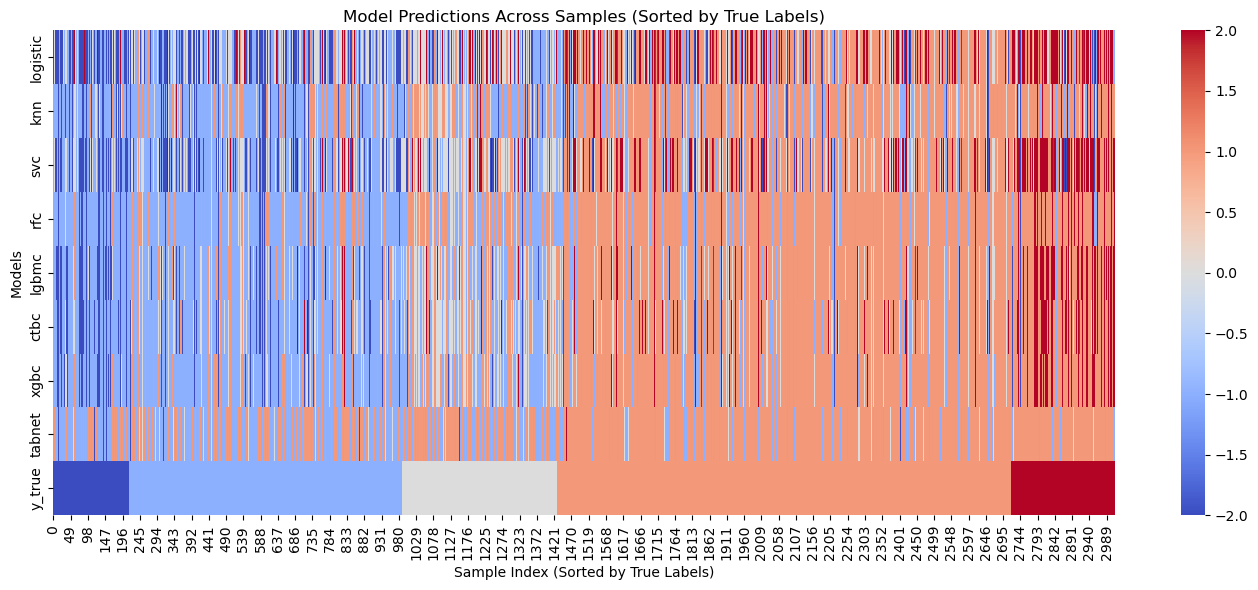

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns


# Sort by true labels for better visualization
sorted_indices = np.argsort(oof_df['y_true'])
oof_df = oof_df.iloc[sorted_indices].reset_index(drop=True)

# reshape to wide format: models x samples
pred_matrix = oof_df.copy().T

plt.figure(figsize=(14, 6))
sns.heatmap(pred_matrix, cmap="coolwarm", cbar=True)
plt.title("Model Predictions Across Samples (Sorted by True Labels)")
plt.xlabel("Sample Index (Sorted by True Labels)")
plt.ylabel("Models")
plt.tight_layout()
plt.show()


## Model Performance Summary
---

### Overall Model Performance

- **Top Performer:**  
  The **LGBMClassifier (`lgbmc`)** achieved the highest overall performance:
  - **F1 Macro:** ~0.49  
  - **F1 Micro:** ~0.586  
  - **Accuracy:** ~0.586  
  Its predictions are well-calibrated and follow the distribution of true labels smoothly.

- **Close Contenders:**  
  **CatBoost (`ctbc`)** and **XGBoost (`xgbc`)** perform similarly to LGBM, with balanced precision and recall across all classes.  
  Together, these three gradient-boosted models form a strong foundation for potential ensembling.

- **Mid-Range Models:**  
  **Random Forest (`rfc`)** and **Support Vector Classifier (`svc`)** achieve moderate performance (accuracy ~0.52–0.54).  
  Their predictions are more scattered, particularly near class boundaries.

- **Lower-Performing Models:**  
  **Logistic Regression** and **kNN** have accuracy below 0.45 and exhibit substantial misclassification for extreme classes.  
  **TabNet** underperforms significantly, with very low F1 Macro (~0.27), indicating that it may require further hyperparameter tuning or better feature preprocessing.

---

### Class-Specific Insights

- **Extreme Classes (-2.0 and 2.0):**  
  XGBoost and CatBoost produce the most consistent predictions for these classes, reducing the number of false negatives.  
  Logistic Regression and kNN frequently misclassify these points toward central classes.

- **Intermediate Classes (-1.0 and 0.0):**  
  Logistic Regression performs relatively well on these classes, reflecting its strength on linearly separable data regions.

- **Class 1.0:**  
  LGBMClassifier demonstrates strong calibration and high recall for this class, outperforming other models.

---

### Heatmap Observations

- Gradient-boosted models (LGBM, CatBoost, XGBoost) produce smooth, continuous prediction patterns that closely match the ground-truth label distribution.
- Linear models (Logistic Regression) and distance-based models (kNN) exhibit more frequent class flips, particularly around decision boundaries.
- TabNet predictions appear noisy and poorly aligned with true labels, indicating underfitting.

---

### Recommendations

1. **Select LGBMClassifier as the primary baseline model** due to its strong overall performance and stability.  
2. **Explore ensemble methods** (soft-voting or stacking) combining LGBM, CatBoost, and XGBoost for further improvements.  
3. **Apply class balancing techniques** (e.g., class weighting, SMOTE, or CTGAN) to improve recall for extreme classes.  
4. **Calibrate probabilistic models** (e.g., SVC, Logistic Regression) using Platt scaling or isotonic regression to improve decision thresholds.

---

### Summary

LGBMClassifier provides the most reliable and consistent results, with CatBoost and XGBoost as strong alternatives. Gradient-boosted models clearly outperform linear, distance-based, and deep learning approaches on this dataset. Logistic Regression and kNN show limited use for central classes only, and TabNet requires significant tuning before being considered viable.


# Feature Importance Analysis

Let's analyze the feature importance for each model to understand which features contribute most to the predictions.

In [111]:
# Get feature names from the dataset
train = pd.read_csv('train.csv')
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
feature_names = [col for col in numeric_cols if col not in ['ID', 'Class.pH']]

print(f"Number of features: {len(feature_names)}")
print(f"Features: {feature_names}")

# Store all trained pipelines for feature importance extraction
pipes = {
    'Logistic Regression': pipe_logistic,
    'KNN': pipe_knn,
    'SVC': pipe_svc, 
    'Random Forest': pipe_rfc,
    'LightGBM': pipe_lgbmc,
    'CatBoost': pipe_ctbc,
    'XGBoost': pipe_xgbc,
    'TabNet': pipe_tabnet
}

Number of features: 15
Features: ['EC', 'OM', 'BD', 'P', 'SAND', 'SILT', 'CLAY', 'N', 'K', 'Ca', 'Mg', 'Na', 'CEC', 'SAR', 'ESP']


In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import warnings

warnings.filterwarnings("ignore")

def get_feature_importance(pipe, feature_names, model_name, X_sample=None, y_sample=None):
    """Extract feature importance from different model types"""
    
    # Get the final model from the pipeline
    model = pipe.named_steps[list(pipe.named_steps.keys())[-1]]
    
    if hasattr(model, 'feature_importances_'):
        # Tree-based models (RF, LGBM, XGB, CatBoost)
        importances = model.feature_importances_
        
    elif hasattr(model, 'coef_'):
        # Linear models (Logistic Regression, SVC with linear kernel)
        if len(model.coef_.shape) > 1:
            # Multi-class: take mean absolute coefficients across classes
            importances = np.mean(np.abs(model.coef_), axis=0)
        else:
            importances = np.abs(model.coef_[0])
            
    elif model_name == 'TabNet':
        # TabNet has feature_importances_ method
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            print(f"TabNet feature importance not available")
            return None
            
    elif model_name in ['KNN', 'SVC']:
        # Use permutation importance for non-linear models
        if X_sample is not None and y_sample is not None:
            perm_importance = permutation_importance(
                pipe, X_sample, y_sample, 
                n_repeats=10, random_state=1516, n_jobs=-1
            )
            importances = perm_importance.importances_mean
        else:
            print(f"Permutation importance requires sample data for {model_name}")
            return None
            
    else:
        print(f"Feature importance not available for {model_name}")
        return None
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances,
        'model': model_name
    }).sort_values('importance', ascending=False)
    
    return importance_df

# Get a sample of data for permutation importance
sample_size = 500
sample_idx = np.random.choice(len(X_train), size=sample_size, replace=False)
X_sample = X_train.iloc[sample_idx]
y_sample = y_train.iloc[sample_idx]

# Extract feature importance for each model
all_importance_data = []

for model_name, pipe in pipes.items():
    if model_name in ['KNN', 'SVC']:
        importance_df = get_feature_importance(pipe, feature_names, model_name, X_sample, y_sample)
    else:
        importance_df = get_feature_importance(pipe, feature_names, model_name)
    
    if importance_df is not None:
        all_importance_data.append(importance_df)

print(f"Successfully extracted feature importance for {len(all_importance_data)} models")

/home/alfi/miniforge3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/alfi/miniforge3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/alfi/miniforge3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81

Successfully extracted feature importance for 8 models


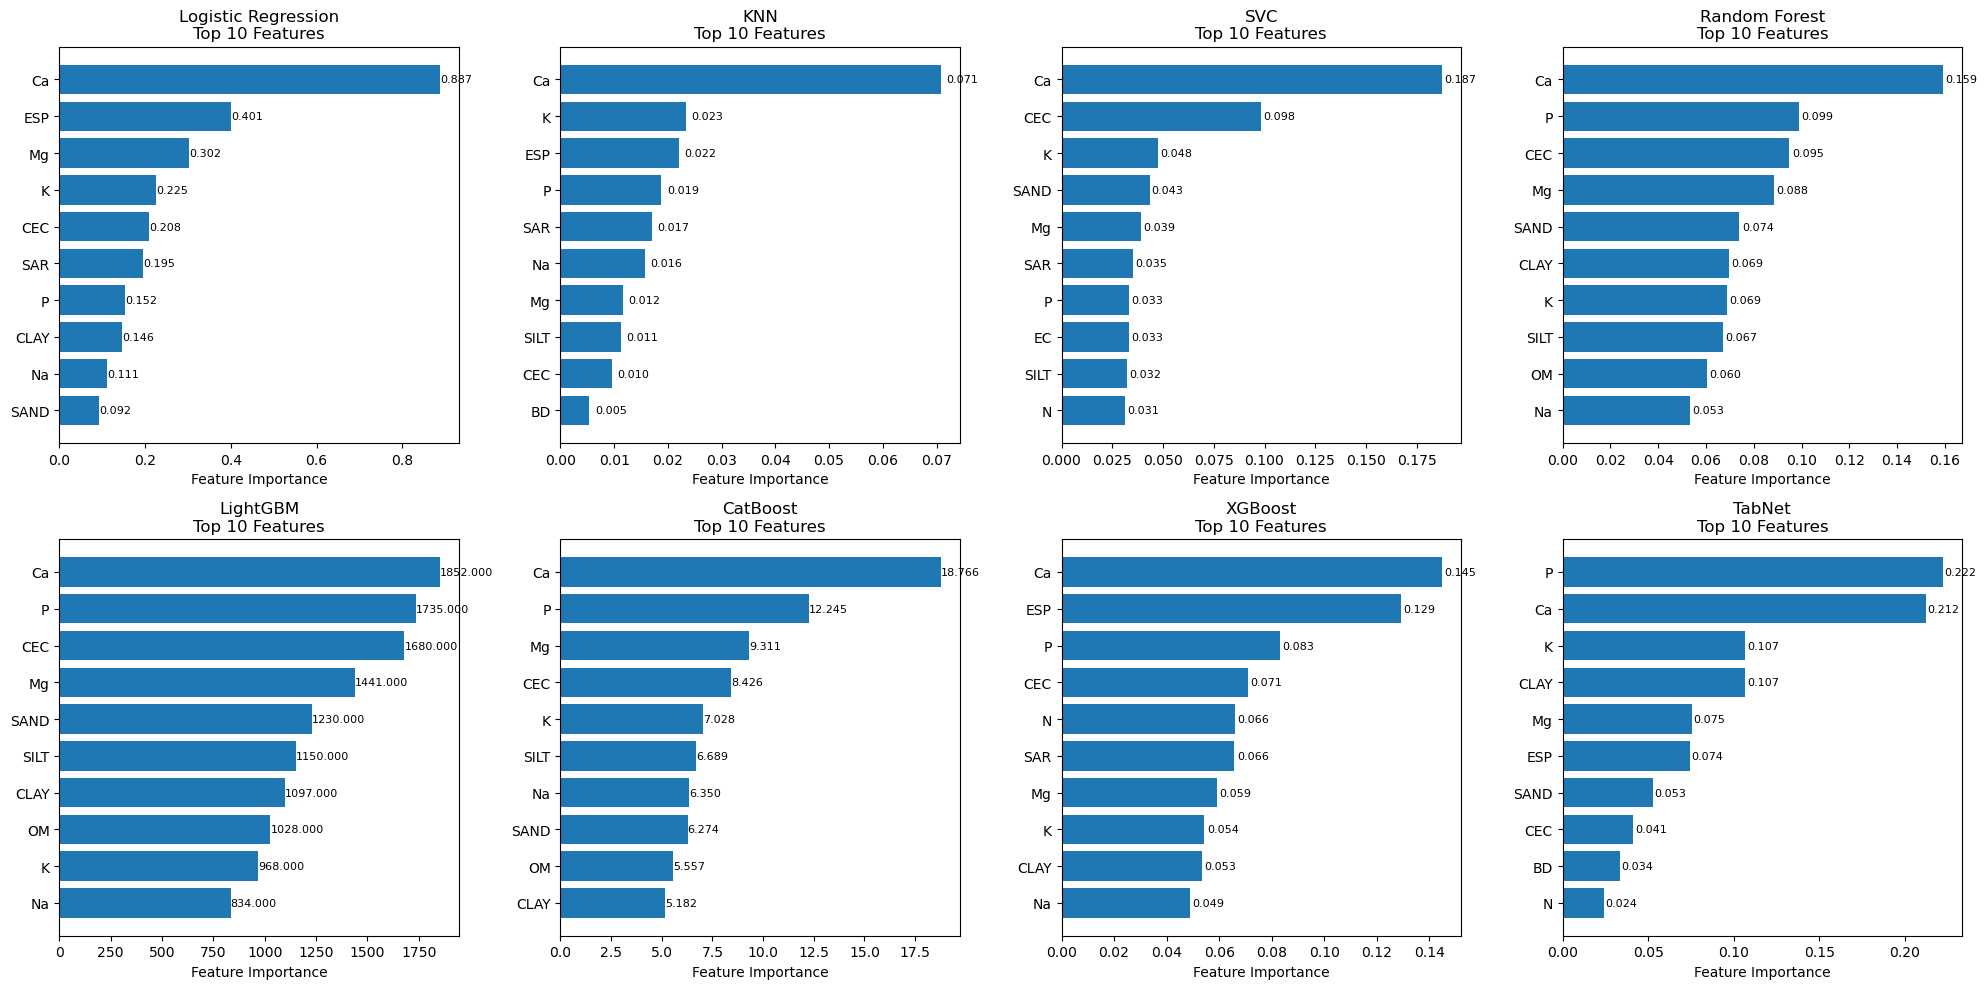

In [113]:
# Create individual feature importance plots for each model
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, importance_df in enumerate(all_importance_data):
    if i >= len(axes):
        break
        
    model_name = importance_df['model'].iloc[0]
    
    # Get top 10 features
    top_features = importance_df.head(10)
    
    # Create horizontal bar plot
    ax = axes[i]
    bars = ax.barh(range(len(top_features)), top_features['importance'])
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'{model_name}\nTop 10 Features')
    ax.invert_yaxis()
    
    # Add value labels on bars
    for j, (bar, val) in enumerate(zip(bars, top_features['importance'])):
        ax.text(val + 0.001, j, f'{val:.3f}', va='center', fontsize=8)

# Hide unused subplots
for i in range(len(all_importance_data), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

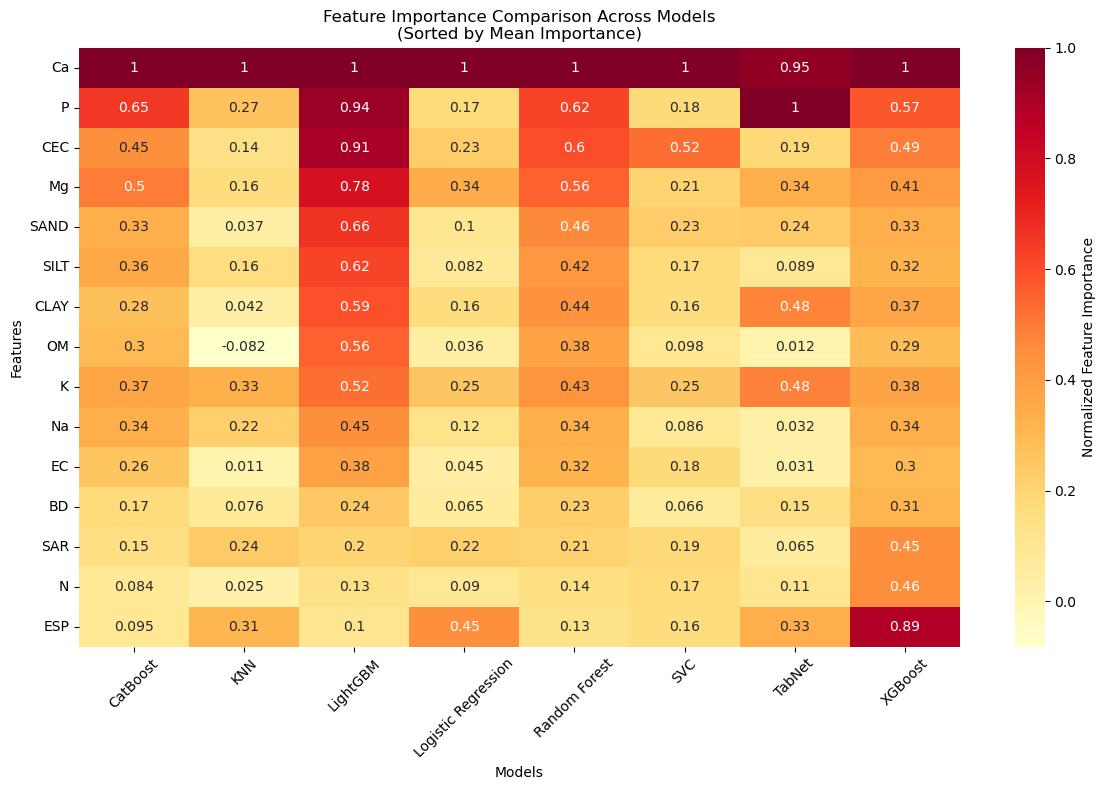

Heatmap shows normalized feature importance across models.
Features are sorted by mean importance across all models.
Darker colors indicate higher relative importance within each model.


In [114]:
# Create a comparative heatmap of feature importance across models
if all_importance_data:
    # Combine all importance data
    all_importance_df = pd.concat(all_importance_data, ignore_index=True)
    
    # Create pivot table for heatmap
    importance_pivot = all_importance_df.pivot(index='feature', columns='model', values='importance')
    
    # Fill NaN values with 0 (for models that don't have importance for certain features)
    importance_pivot = importance_pivot.fillna(0)
    
    # Calculate mean importance across models for sorting
    importance_pivot['mean_importance'] = importance_pivot.mean(axis=1)
    importance_pivot_sorted = importance_pivot.sort_values('mean_importance', ascending=False)
    
    # Remove the mean column for visualization
    importance_pivot_norm = importance_pivot_sorted.drop('mean_importance', axis=1)
    importance_pivot_norm = importance_pivot_norm.div(importance_pivot_norm.max(), axis=1)
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_pivot_norm, 
                annot=True, 
                cmap='YlOrRd', 
                cbar_kws={'label': 'Normalized Feature Importance'})
    plt.title('Feature Importance Comparison Across Models\n(Sorted by Mean Importance)')
    plt.xlabel('Models')
    plt.ylabel('Features')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("Heatmap shows normalized feature importance across models.")
    print("Features are sorted by mean importance across all models.")
    print("Darker colors indicate higher relative importance within each model.")

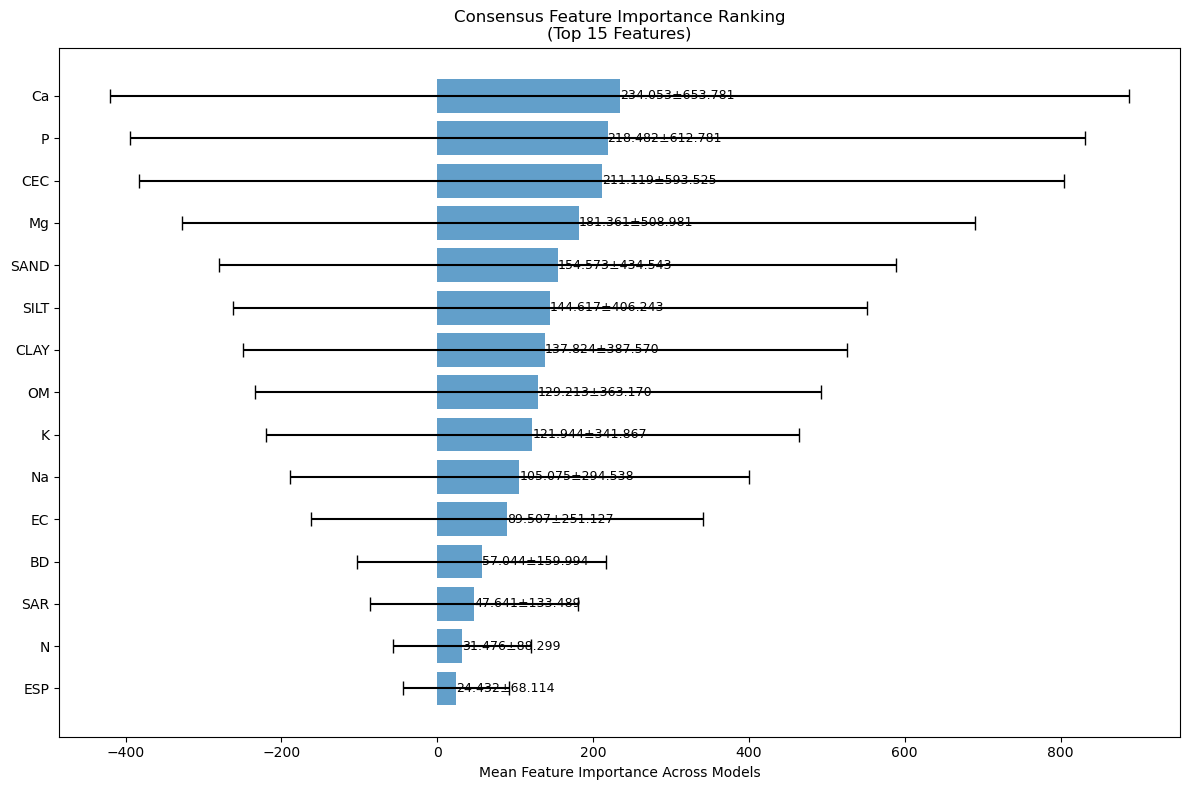

Top Important Features (Consensus):
feature       mean        std
     Ca 234.053403 653.781212
      P 218.481664 612.780679
    CEC 211.118598 593.524889
     Mg 181.360921 508.981271
   SAND 154.573340 434.543445
   SILT 144.617223 406.242647
   CLAY 137.823857 387.569823
     OM 129.213305 363.169827
      K 121.944173 341.866811
     Na 105.075273 294.538341
     EC  89.507284 251.126725
     BD  57.044364 159.993991
    SAR  47.640824 133.488634
      N  31.475576  88.298851
    ESP  24.432404  68.114212


In [115]:
# Create consensus feature importance ranking
if all_importance_data:
    # Calculate mean importance across all models
    consensus_importance = all_importance_df.groupby('feature')['importance'].agg(['mean', 'std', 'count']).reset_index()
    consensus_importance = consensus_importance.sort_values('mean', ascending=False)
    
    # Create ranking plot
    plt.figure(figsize=(12, 8))
    
    # Top 15 features
    top_consensus = consensus_importance.head(15)
    
    bars = plt.barh(range(len(top_consensus)), top_consensus['mean'], 
                    xerr=top_consensus['std'], capsize=5, alpha=0.7)
    
    plt.yticks(range(len(top_consensus)), top_consensus['feature'])
    plt.xlabel('Mean Feature Importance Across Models')
    plt.title('Consensus Feature Importance Ranking\n(Top 15 Features)')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, (mean_val, std_val) in enumerate(zip(top_consensus['mean'], top_consensus['std'])):
        plt.text(mean_val + 0.001, i, f'{mean_val:.3f}±{std_val:.3f}', 
                va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

    print("Top Important Features (Consensus):")
    print(consensus_importance[['feature', 'mean', 'std']].to_string(index=False))

## Feature Importance Analysis

This section integrates feature importance results from multiple models (Logistic Regression, KNN, SVC, Random Forest, LightGBM, CatBoost, XGBoost, and TabNet) to identify consistent predictors of soil pH classification.

---

### Consistent Top Features Across Models

- **Calcium (Ca):**  
  Emerges as the most important feature across all models, with the highest weight in Logistic Regression, tree-based models (LightGBM, CatBoost, XGBoost), and strong influence in TabNet.  
  Interpretation: Ca is the dominant driver of soil pH variation.

- **Phosphorus (P):**  
  Highly ranked in Logistic Regression, CatBoost, LightGBM, and TabNet.  
  Interpretation: P availability is strongly linked with soil acidity/alkalinity levels.

- **Cation Exchange Capacity (CEC):**  
  Consistently appears in the top five for tree-based and linear models, confirming its central role in buffering soil pH.

- **Magnesium (Mg):**  
  Ranked strongly by CatBoost, LightGBM, Logistic Regression, and SVC.  
  Interpretation: Secondary nutrient contributing to cation balance and pH variation.

- **Soil Texture (SAND, SILT, CLAY):**  
  While less dominant than Ca or P, texture features consistently appear in the top 10, particularly in ensemble models.  
  Interpretation: Texture indirectly influences pH through water retention and cation exchange dynamics.

---

### Model-Specific Patterns

- **Linear Models (Logistic Regression, SVC):**  
  Strongly emphasize Ca, followed by Mg, K, and CEC. ESP and SAR also emerge in Logistic Regression.  
  Interpretation: Linear separation is largely driven by major cations.

- **KNN:**  
  Assigns lower importance overall, but Ca remains the top feature. Other variables show weak influence.  
  Interpretation: Local similarity is mainly captured through Ca levels.

- **Tree-Based Models (Random Forest, LightGBM, CatBoost, XGBoost):**  
  Place heavy importance on Ca, P, CEC, and Mg, with texture variables and Na contributing additional signal.  
  Interpretation: These models capture nonlinear relationships and interactions.

- **TabNet:**  
  Prioritizes P and Ca, with K, CLAY, and Mg also contributing.  
  Interpretation: Neural attention aligns partially with ensemble models but shifts emphasis toward P.

---

### Consensus Ranking (Mean Importance Across Models)

| Rank | Feature | Interpretation |
|------|----------|----------------|
| 1 | **Ca** | Primary driver of soil pH variation |
| 2 | **P** | Strong secondary predictor |
| 3 | **CEC** | Reflects buffering and ion retention |
| 4 | **Mg** | Secondary cation influencing balance |
| 5–7 | **SAND, SILT, CLAY** | Indirect effects through soil structure |
| 8 | **OM** | Moderately important across models |
| 9 | **K** | Secondary but consistent contributor |
| 10 | **Na** | Important in some models, less universal |
| 11–15 | **EC, BD, SAR, N, ESP** | Lower relevance, limited predictive contribution |

---

### Practical Implications

1. **Feature Selection:**  
   Models can achieve strong performance focusing on a reduced set of features: **Ca, P, CEC, Mg, and texture variables (SAND, SILT, CLAY)**.  
   Supporting features (OM, K, Na) may be retained but contribute less.

2. **Domain Alignment:**  
   The results align with agronomic knowledge: calcium, phosphorus, and cation exchange capacity are central to soil acidity and fertility management.

3. **Modeling Strategy:**  
   - Linear models: emphasize Ca and Mg.  
   - Tree-based models: capture additional texture and nonlinear effects.  
   - Neural/tabular models: emphasize both Ca and P.  
   This suggests ensemble approaches can balance complementary feature usage.

---

### Summary

Across all models, **Calcium (Ca)** is the single most critical predictor of soil pH classes, followed by **Phosphorus (P), CEC, and Magnesium (Mg)**. Soil texture variables contribute indirectly, while features such as **N, EC, BD, SAR, and ESP** play relatively minor roles. These findings support focusing modeling and interpretation on a core group of chemical features complemented by texture information.
